In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [3]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch

In [46]:
start_ix = 0
num_model = 128

In [47]:
vmodel = []
pmodel = []

for i in range(start_ix, start_ix + num_model):
    vmodel.append(torch.load(f'model/vmodel-{i}.pt'))
    pmodel.append(torch.load(f'model/pmodel-{i}.pt'))

In [48]:
p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])

In [49]:
ps = []
qs = []
for i in range(num_model):
    p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
    q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]
    ps.append(p)
    qs.append(q)
df = pd.DataFrame({'p': ps, 'q': qs})

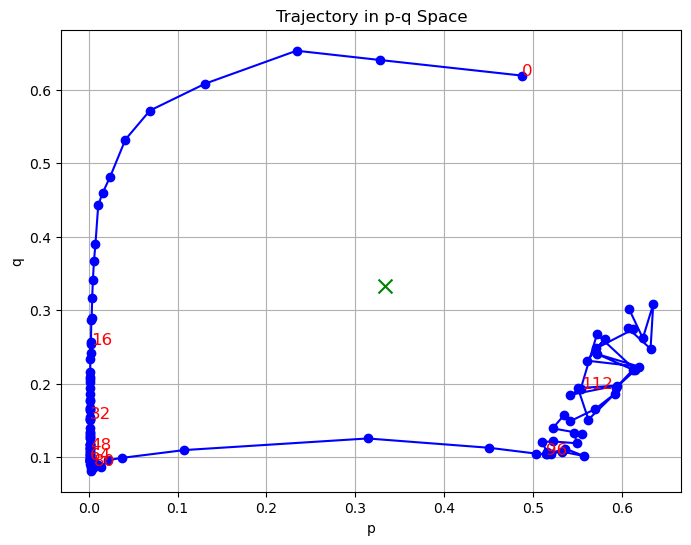

In [50]:
data = df

plt.figure(figsize=(8, 6)) 
plt.plot(data['p'], data['q'], marker='o', linestyle='-', color='b')
plt.title('Trajectory in p-q Space') 
plt.xlabel('p')  
plt.ylabel('q') 
plt.grid(True) 

# Annotate every 10th point with its order number
for i, (p, q) in enumerate(zip(data['p'], data['q'])):
    if i % 16 == 0: 
        plt.text(p, q, str(i), color="red", fontsize=12)
        
plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

plt.show()

In [9]:
with open('self_play_games/self_play_games.pkl', 'rb') as f:
    games = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'self_play_games/self_play_games.pkl'

In [ ]:
games

In [ ]:
games[1]

In [ ]:
data = SelfPlayDataV(games)

In [ ]:
list(data)[1]